In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata
import pickle
import pandas as pd

In [2]:
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [7]:
df = pd.read_csv("fulldataset_updated.csv")
df2 = pd.read_csv("archive/movie_metadata/movie_meta_data.csv")


df = df.drop(columns=["title", "script department", "production companies", "writers", "directors", "casting directors", "cast"])
df["synopsis"] = df["imdbid"].apply(lambda x: df2.loc[df2['imdbid'] == x]["synopsis"].values[0] if len(df2.loc[df2['imdbid'] == x]["synopsis"].values) > 0 else np.nan)

df = df.dropna(axis=0)

normdata = pre_process_corpus(df["synopsis"].values)

 64%|██████▎   | 801/1261 [00:00<00:00, 1057.63it/s]C:\Users\Edan\AppData\Local\Temp\ipykernel_13672\1829036669.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 1261/1261 [00:01<00:00, 993.67it/s] 


In [8]:
t = Tokenizer(oov_token='<UNK>')
t.fit_on_texts(normdata)
t.word_index['<PAD>'] = 0

In [9]:
sequences = t.texts_to_sequences(normdata)

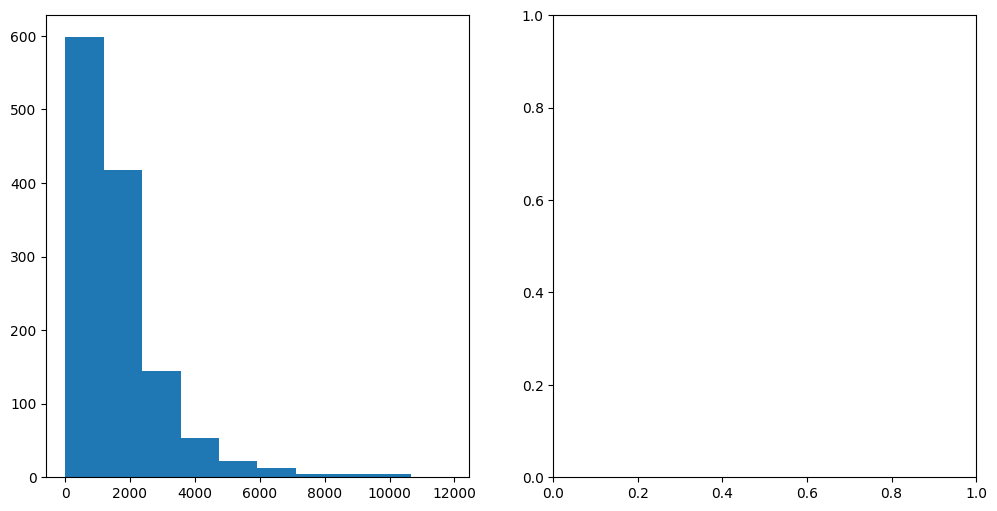

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)

In [11]:
MAXLEN = 7000
preparedData = pad_sequences(sequences, maxlen=MAXLEN)

In [12]:
df = df.reset_index(drop=True)


In [13]:
df["synopsis sequences"] = df.apply(lambda x: preparedData[x.name],axis=1)


In [14]:
df = df.drop(columns=["synopsis"])

In [15]:
with open("tokenizeddata_updated.pkl", "wb") as f:
    pickle.dump(df,f)

In [16]:
len(t.word_index)

65094